# CSCI 591: Deep Learning
## Lab 1 - Torch Refresher


### Overview
Today, we're going to spend some time refamiliarizing ourselves with pytorch: how to read data, write down neural networks, evaluate loss functions, and perform optimization.  Pytorch offers many ways to do all of these things at different layers of abstraction.  We'll go through a very low-level implementation of a special very interesting type of neural network together before implementing a similar model using the higher-level module API on your own.  Finally, we'll explore the use of pytorch-lightning, which abstracts away most of the boilerplate optimization code and is very clean.

### The model
The model that we're going to implement today is called an *autoencoder*.  That sounds fancy, but the idea is actually very straightforward to understand and implement: it's a neural network that is trained to recreate as output its input.  Assuming we have an input called $\mathbf{x}\in \mathbb{R}^n$, an autoencoder has two parts, the *encoder*
$$
\mathbf{z} = E(\mathbf{x};\mathbf{W}_e),
$$
which creates an encoded representation of the input called $\mathbf{z}\in \mathbb{R}^h$, and a decoder
$$
\mathbf{x}' = D(\mathbf{z};\mathbf{W}_d),
$$
which takes that encoded representation, and decodes it back to an output that looks like the input.  Both the encoder and decoder are typically neural networks, and each have their own parameters.  Here's an image of such a network:
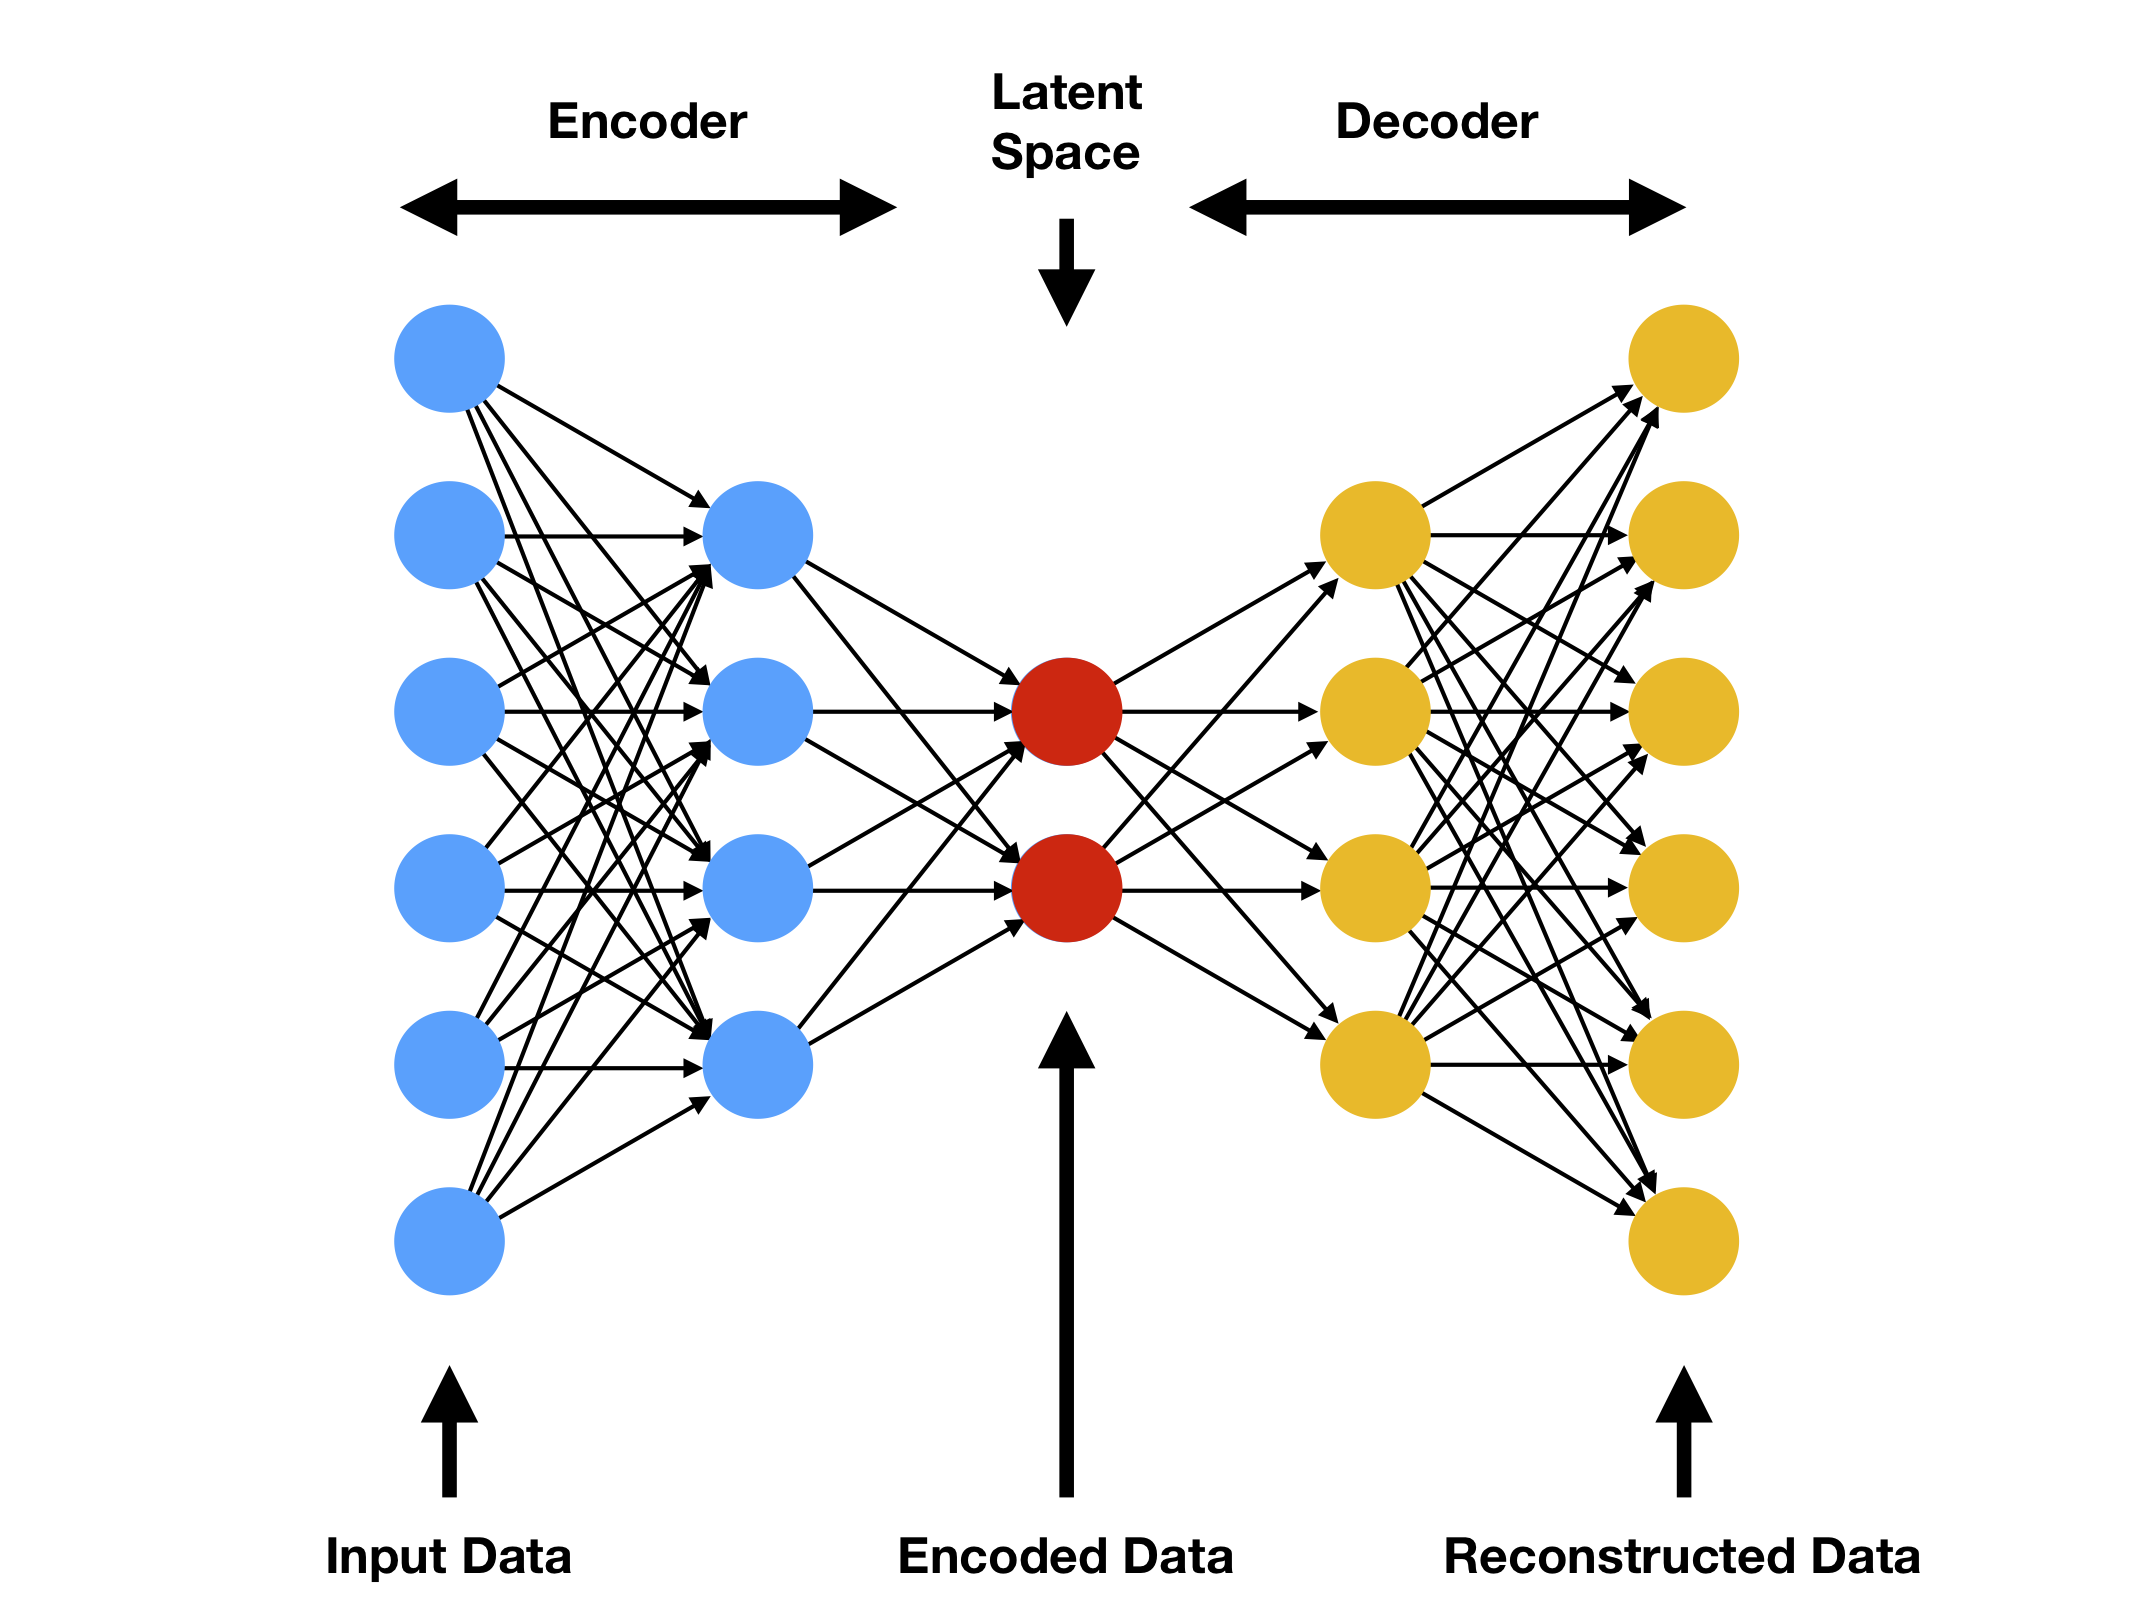

Because we'd like the output to recreate the input, and the input in this case is real-valued by assumption, a reasonable (although not necessarily ideal, as we will see later in the course) cost function (or likelihood or objective function or loss function, whatever you want to call it) could be mean square error:
$$
\mathcal{L}(\mathbf{x},\mathbf{x}') = \frac{1}{m n} \sum_{i=1}^m \sum_{j=1}^n \big( \mathbf{x}_{ij} - \mathbf{x}'_{ij} \big)^2.
$$
which we can minimize via stochastic gradient descent or some variant thereof.  

A reasonable question to ask at this point might be: why is this a useful thing to do?  Note that in the above image, the encoded representation (often called the latent space) is of substantially lower dimensionality than the input or output, i.e. $h<<n$, yet we would still like to be able to recover the input from this much lower dimensional representation of the data.  What this means is that this network is being forced to learn a *compressed* representation of the input that loses as little information as possible.  This compressed representation is useful on its own, but also can be used as the input to a different classifier, among a variety of other uses, some of which we'll see when we study a variant called variational autoencdoers (VAEs).

### The data
It will be interesting to apply this method to a non-trivial dataset.  Here, we'll use [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 60000 small (32x32) RGB images.  It ends up being pretty fun to look at the latent space.

It's quite easy to read this data into pytorch using its extension [torchvision](https://pytorch.org/vision/stable/index.html) (this may take a minute to run the first time)

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

Here, we'll define an object to load batches of the dataset from file for the purpose of SGD.  In the process, we'll normalize the images to have pixel values that map from -1 to 1.  

In [ ]:
# a sequence of operations that are applied to the data as its read in (you can do data augmentation here)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# The size of the batches that we'd like to read.  
batch_size = 256

# The dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# The dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

It's (sort of) easy to look at some elements in the data:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# grab a batch of data from the loader, discard the labels (which we're not using), and convert it to numpy
example = iter(trainloader).next()[0].numpy()

# Convert the data back to [0,1] range for plotting, convert from channels-first to channels-last representation
example = np.rollaxis(0.5*(example + 1),1,4)

plt.imshow(example[0])

### Low-level implementation
Let's implement a neural network using the most basic operations of torch, just tensor multiplication and addition.  Note that these operations are overloaded in pytorch, and as we perform them we save a computational graph which can be used for automatic differenation (which we'll talk more about next week).  

Our neural network will be very simple, in this case: just a single linear transformation for the encoder and the same for the decoder:

In [ ]:
n = 3072            # input features
latent_size = 2     # Very small! hidden layer size

# Encoder parameters (note the requires_grad flag!)
W1_e = torch.randn(n,latent_size,requires_grad=True)   # Encoder weights 
b1_e = torch.randn(1,latent_size,requires_grad=True)   # Encoder bias

# Decoder parameters
W2_d = torch.randn(latent_size,n,requires_grad=True)   # Decoder weights
b2_d = torch.randn(1,n,requires_grad=True)             # Decoder bias

# Put them all in a list
params = [W1_e,b1_e,W2_d,b2_d]

# Scale them to be a bit more reasonable initial guesses (although there are better ways of doing this)
for p in params:
    p.data*=1e-3

That's all there is to it to initialize the neural net.  A sensible implementation would wrap this stuff in functions, but we're trying to be as explicit as possible.  Now, let's perform gradient descent.  We'll need to define a learning rate and number of epochs to train for:

In [ ]:
lr = 1.0
n_epochs = 20
for i in range(n_epochs):
    for X,_ in trainloader:
        X = X.view(-1, n)               # Reshape the image to be flattened (when we do CNNs, we'll keep shape)
        z = X @ W1_e + b1_e             # Encoder step
        X_prime = torch.tanh(z @ W2_d + b2_d)       # Decoder step

        # Compute MSE
        L = torch.mean((X - X_prime)**2)
        
        # Backpropagate gradients
        L.backward()

        # Update parameter values using gradient descent
        for p in params:
            p.data -= lr*p.grad
            p.grad[:] = 0              # Clear gradient buffer
            
    print(f"Epoch: {i}, Loss: {L.item()}")


Great, we've successfully trained!  Now, let's plot some of the original images against the reconstruction!

In [ ]:
X_np = 0.5*(np.rollaxis(X.reshape(-1,3,32,32).detach().numpy(),1,4)+1)
Xprime_np = 0.5*(np.rollaxis(X_prime.reshape(-1,3,32,32).detach().numpy(),1,4)+1)
fig,axs = plt.subplots(nrows=3,ncols=2)
for ax in axs:
    j = np.random.randint(X.shape[0])
    ax[0].imshow(X_np[j])
    ax[1].imshow(Xprime_np[j])
fig.set_size_inches(5,10)

A bit underwhelming.  However, we did ask for something rather difficult: to compress images down into only two numbers (two latent space values) using only linear transformations.  That's a hard task!  Indeed, if we try again with a larger latent space dimension, we'll get better results.  However, the advantage here is that the latent space is amenable to having its structure visualized, for example by: 

In [ ]:
fig,axs = plt.subplots()

X,_ = iter(trainloader).next()

X = X.view(-1, n)               # Reshape the image to be flattened (when we do CNNs, we'll keep shape)
z = X @ W1_e + b1_e             # Encoder step
X_prime = torch.tanh(z @ W2_d + b2_d)       # Decoder step


Xprime_np = 0.5*(np.rollaxis(X_prime.reshape(-1,3,32,32).detach().numpy(),1,4)+1)
X_np = 0.5*(np.rollaxis(X.reshape(-1,3,32,32).detach().numpy(),1,4)+1)
s = 1.5
z_np = z.detach().numpy()
for x,z in zip(Xprime_np,z_np):
    axs.imshow(x,extent=[z[0]-s,z[0]+s,z[1]-s,z[1]+s],alpha=1.0)

axs.set_xlim(-20,20)
axs.set_ylim(-20,20)
fig.set_size_inches(10,10)

Fuzzy as it is, there's some organization: background gradient and the contrast of the central object seem to be the learned feature.  

### Implementation  using torch.nn.  
This is a simple model trained using a very simple optimizer.  We can make our life easier for both using the torch.nn and torch.optim modules.  

To build a nicely wrapped neural network, we'll subclass the torch.nn.Module object.  We don't need to delve too deeply into the parent class, but what it does it to automatically account for which of its parameters are trainable, and also to automatically implement the .backward() method for backpropagating gradients.  It requires an init method that calls the __init__ of the parent class as well as a forward method, which takes an input tensor and applies the requested operations. 

Here's the above model implemented using torch.nn

In [ ]:
class AE(torch.nn.Module):
    
    def __init__(self,input_size,latent_size):
        super().__init__()
        
        self.encoder = torch.nn.Linear(input_size,latent_size)  # This includes both a weight and bias
        self.decoder = torch.nn.Sequential(torch.nn.Linear(latent_size,input_size),torch.nn.Tanh())
        
    def forward(self,X):
        z = self.encoder(X)         # Apply the encoder
        Xprime = self.decoder(z)    # Apply the decoder
        return(Xprime,z)            # Return the result (and the latent space variable)
            
autoencoder = AE(3072,2)

Super simple!  

We can also use torch's built-in optimizers rather than encode them from scratch as we did above.  This is done by just passing in the model's parameters to the optimizer to keep track of, along with a learning rate (and other optimizer-specific parameters if so desired).  

In [ ]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

This object will work on the gradients of all of the parameters that it's been told to account for when the .step() method is called (note that you can also mix and match optimizers for different parameters if that's what you want to do).  

We can also use nn's implementation of cost functions: here's MSE

In [ ]:
L = torch.nn.MSELoss()

Now we can use a similar training loop to the one above to optimize the autoencoder

In [ ]:
n_epochs = 15
for epoch in range(n_epochs):
    loss = 0
    for X,_ in trainloader:

        X = X.view(-1, 3072)
        optimizer.zero_grad()                       # Clear gradients
        
        # compute reconstructions
        X_prime,Z = autoencoder(X)
        
        # compute training reconstruction loss
        train_loss = L(X,X_prime)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(trainloader)
    
    # display the epoch training loss
    print(f"epoch : {epoch + 1}/{n_epochs}, loss = {loss}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
j = np.random.randint(X.shape[0])

X_np = 0.5*(np.rollaxis(X.reshape(-1,3,32,32).detach().numpy(),1,4)+1)
Xprime_np = 0.5*(np.rollaxis(X_prime.reshape(-1,3,32,32).detach().numpy(),1,4)+1)
fig,axs = plt.subplots(ncols=2)
axs[0].imshow(X_np[j])
axs[1].imshow(Xprime_np[j])

In [ ]:
fig,axs = plt.subplots(ncols=2)

X,_ = iter(trainloader).next()

X_prime,z = autoencoder(X.view(-1,n))      # Decoder step

Xprime_np = 0.5*(np.rollaxis(X_prime.reshape(-1,3,32,32).detach().numpy(),1,4)+1)
X_np = 0.5*(np.rollaxis(X.reshape(-1,3,32,32).detach().numpy(),1,4)+1)
s = 0.2
z_np = z.detach().numpy()
for x,xp,z in zip(X_np,Xprime_np,z_np):
    axs[0].imshow(xp,extent=[z[0]-s,z[0]+s,z[1]-s,z[1]+s],alpha=1.0)
    axs[1].imshow(x,extent=[z[0]-s,z[0]+s,z[1]-s,z[1]+s],alpha=1.0)

axs[0].set_xlim(-2,2)
axs[0].set_ylim(-2,2)

axs[1].set_xlim(-2,2)
axs[1].set_ylim(-2,2)
fig.set_size_inches(20,10)

Essentially the same result, although probably a bit better because Adam is a much more performant optimizer.  

Let's try to do the above using a higher-dimensional latent space.  

In [ ]:
autoencoder = AE(3072,256)

The remainder of the code is as before

In [ ]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
L = torch.nn.MSELoss() # Redundant, but here for clarity

n_epochs = 15
for epoch in range(n_epochs):
    loss = 0
    for X,_ in trainloader:

        X = X.view(-1, 3072)
        optimizer.zero_grad()                       # Clear gradients
        
        # compute reconstructions
        X_prime,Z = autoencoder(X)
        
        # compute training reconstruction loss
        train_loss = L(X,X_prime)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(trainloader)
    
    # display the epoch training loss
    print(f"epoch : {epoch + 1}/{n_epochs}, loss = {loss}")


Now we can perform a similar graphical analysis to before

In [ ]:
fig,axs = plt.subplots(ncols=2)

X,_ = iter(trainloader).next()

X_prime,z = autoencoder(X.view(-1,n))      # Decoder step

Xprime_np = 0.5*(np.rollaxis(X_prime.reshape(-1,3,32,32).detach().numpy(),1,4)+1)
X_np = 0.5*(np.rollaxis(X.reshape(-1,3,32,32).detach().numpy(),1,4)+1)
s = 0.2
z_np = z.detach().numpy()
for x,xp,z in zip(X_np,Xprime_np,z_np):
    axs[0].imshow(xp,extent=[z[0]-s,z[0]+s,z[1]-s,z[1]+s],alpha=1.0)
    axs[1].imshow(x,extent=[z[0]-s,z[0]+s,z[1]-s,z[1]+s],alpha=1.0)

axs[0].set_xlim(-2,2)
axs[0].set_ylim(-2,2)

axs[1].set_xlim(-2,2)
axs[1].set_ylim(-2,2)
fig.set_size_inches(20,10)

Note that we've got a much better reconstruction of the image, but the latent space interpretation isn't so clear.  This is because this is just two axes out of 256!  These two are probably encoding some detail, but exactly what is not at all apparent.  How about we search for the axes in latent space that are the most important and plot those instead?  First, let's get latent space values for all 50000 examples (rather than just the last batch).

In [ ]:
# Batch process all of the training examples

zs = []
xs = []
x0s = []
for X,_ in trainloader:
    x,z = autoencoder(X.view(-1,3072))
    zs.append(z)
    xs.append(x)
    x0s.append(X.view(-1,3072))
Z = torch.cat(zs)
X_r = torch.cat(xs)
X0_r = torch.cat(x0s)

Now, we can perform a principal component analysis in latent space, and use those principal component directions as our latent space.  I'm going to use a shortcut via singular value decomposition, but this is still just a simple PCA.

In [ ]:
U,S,V = torch.svd(Z)

In [ ]:
fig,axs = plt.subplots()

Z_np = U.detach().numpy() @ np.diag(S.detach().numpy())
Xprime_np = 0.5*(np.rollaxis(X_r.reshape(-1,3,32,32).detach().numpy(),1,4)+1)
X_np = 0.5*(np.rollaxis(X0_r.reshape(-1,3,32,32).detach().numpy(),1,4)+1)
s = 1.0
index_0 = 0
index_1 = 1
n_images = 100
indices = np.random.randint(Z_np.shape[0],size=n_images)
for x,z in zip(X_np[indices],Z_np[indices]):
    axs.imshow(x,extent=[z[index_0]-s,z[index_0]+s,z[index_1]-s,z[index_1]+s],alpha=1.0)

axs.set_xlim(-15,15)
axs.set_ylim(-15,15)
fig.set_size_inches(10,10)

# Your turn
Here, we've developed a simple autoencoder to look at a latent space represenation of the CIFAR-10 data.  Your assignment is a choose your own adventure.  You can

#### Choice 1) Go deeper with AEs
Make two substantive changes to the architecture or optimization procedure described above.  This might be adding hidden layers, changing the optimizer, adding regularization, altering the objective function (L1 loss?) or something similar.  Implement those changes below and write a few sentences about the implications of these changes for the analysis of the latent space (if there are any), and whether that is consistent with your expectations

#### Choice 2) Make a classifier
It is straightforward to change the code above to actually perform supervised classification (the labels are the second output from trainloader, which is currently assigned to "\_") by altering the objective function and neural network architecture.  Build a classifier, and report training set accuracy (don't worry about a test set right now: our goal is to refamiliarize yourself with torch, not to validate the classifier).  

Feel free to work in small groups.  Turn this assignment in by forking this repository and making a pull request.  